In [47]:
import os
import shutil
import uuid
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from timm import create_model
from tqdm import tqdm
from PIL import Image

In [48]:
# ⚠️ Manually update this path before running
SURPRISE_INPUT_FOLDER = "./Unsplitted_Ready_Sets/set_01_raw_mix/Surprise"  # Replace with the actual path
SURPRISE_OUTPUT_FOLDER = "./Unsplitted_Ready_Sets/set_02_raw_class_balanced/Surprise"  # Where selected images will be stored
TARGET_IMAGE_COUNT = 7382  # Number of images to save

# Model categories (Must match training order)
MODEL_CATEGORIES = ["Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

In [39]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# Load Model
MODEL_PATH = "adaptive_efficientnetv2_rw_s_emotion_model.pth"

def load_model(model_path, num_classes=8):
    print("🔄 Loading the trained EfficientNet-B2 model...")
    model = create_model('efficientnetv2_rw_s', pretrained=False, num_classes=num_classes, in_chans=1)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    print("✅ Model loaded successfully!")
    return model

✅ Using device: cuda


In [40]:
# Define image transformation (grayscale processing)
image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((260, 260)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Load model
model = load_model(MODEL_PATH)

🔄 Loading the trained EfficientNet-B2 model...


C:\Users\Tuf\AppData\Local\Temp\ipykernel_14384\2480567632.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=dev

✅ Model loaded successfully!


In [41]:
# Step 1: Create the output folder if it doesn't exist
def initialize_output_folder():
    if not os.path.exists(SURPRISE_OUTPUT_FOLDER):
        os.makedirs(SURPRISE_OUTPUT_FOLDER)

In [49]:
# Step 2: Process and filter only "Surprise" images
def filter_top_surprise_images():
    image_paths = [
        os.path.join(SURPRISE_INPUT_FOLDER, file) for file in os.listdir(SURPRISE_INPUT_FOLDER)
        if file.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    print(f"📂 Processing {len(image_paths)} Surprise images...")

    confidence_scores = []  # Store confidence scores for ranking

    # Step 2.1: Process all images and collect confidence scores
    with tqdm(total=len(image_paths), desc="Analyzing Surprise") as pbar:
        for img_path in image_paths:
            try:
                # Load and process the image
                img = Image.open(img_path).convert("L")  
                input_tensor = image_transform(img).unsqueeze(0).to(device)

                # Get model prediction
                with torch.no_grad():
                    output = model(input_tensor)
                    probabilities = torch.nn.functional.softmax(output, dim=1)
                    confidence, predicted = torch.max(probabilities, 1)

                predicted_emotion = MODEL_CATEGORIES[predicted.item()]
                confidence_value = confidence.item()

                # If predicted as "Surprise", store it for ranking
                if predicted_emotion == "Surprise":
                    confidence_scores.append((img_path, confidence_value))

                pbar.update(1)  # Update progress bar

            except Exception as e:
                print(f"⚠️ Error processing {img_path}: {e}")
                pbar.update(1)  # Ensure progress bar continues

    # Step 2.2: Sort by confidence (Descending order)
    confidence_scores.sort(key=lambda x: x[1], reverse=True)

    # Step 2.3: Select the top 7382 most confident images
    selected_images = confidence_scores[:TARGET_IMAGE_COUNT]

    print(f"\n✅ Selected {len(selected_images)} highest confidence 'Surprise' images.")

    # Step 2.4: Save the selected images
    with tqdm(total=len(selected_images), desc="Saving Top Surprise Images") as pbar:
        for img_path, conf in selected_images:
            try:
                unique_name = str(uuid.uuid4())[:8] + "_" + os.path.basename(img_path)
                target_path = os.path.join(SURPRISE_OUTPUT_FOLDER, unique_name)
                shutil.copy(img_path, target_path)
                pbar.update(1)
            except Exception as e:
                print(f"⚠️ Error copying {img_path}: {e}")
                pbar.update(1)

    # Generate and show the confidence distribution plot
    plot_confidence_distribution([conf for _, conf in confidence_scores])

    print(f"\n✅ Processing completed! Saved {len(selected_images)} 'Surprise' images to: {SURPRISE_OUTPUT_FOLDER}")

# Step 3: Plot Confidence Distribution
def plot_confidence_distribution(confidence_scores):
    if not confidence_scores:
        print("⚠️ No valid confidence scores to plot.")
        return

    plt.figure(figsize=(10, 5))
    sns.histplot(confidence_scores, bins=30, kde=True, color="blue")
    plt.xlabel("Confidence Score")
    plt.ylabel("Frequency")
    plt.title("Confidence Distribution for Surprise Predictions")
    plt.grid()
    plt.show()

📂 Processing 9198 Surprise images...


Analyzing Surprise: 100%|██████████| 9198/9198 [10:08<00:00, 15.11it/s]



✅ Selected 7382 highest confidence 'Surprise' images.


Saving Top Surprise Images: 100%|██████████| 7382/7382 [00:09<00:00, 787.00it/s]


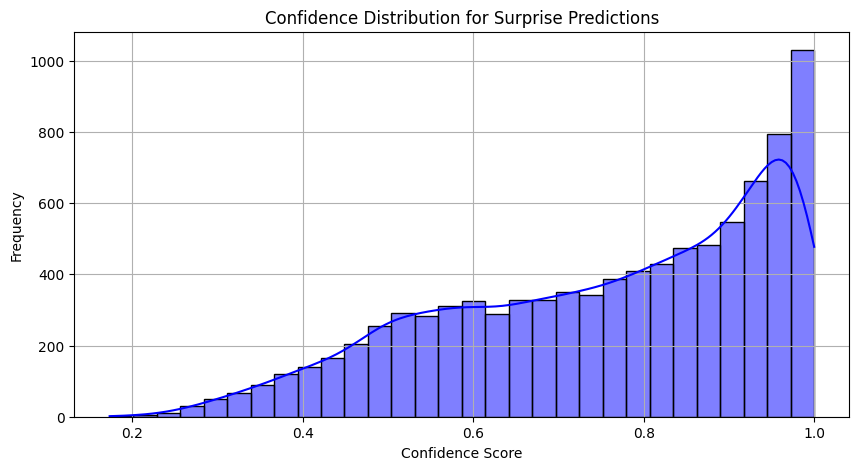


✅ Processing completed! Saved 7382 'Surprise' images to: ./Unsplitted_Ready_Sets/set_02_raw_class_balanced/Surprise


In [50]:
# Run the script
if __name__ == "__main__":
    initialize_output_folder()
    filter_top_surprise_images()